<a href="https://colab.research.google.com/github/OlyKoek/Udemy-AIperfectMaster-colabo/blob/main/lstm_rnn_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# シンプルなLSTMとRNNとTransformerの実装と比較

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, SimpleRNN, LSTM, Input, MultiHeadAttention, Add, LayerNormalization

## 訓練用データの作成
RNNに用いる訓練用のデータを作成します。  
サイン関数に乱数でノイズを加えたデータを作成し、過去の時系列データから未来の値を予測できるようにします。

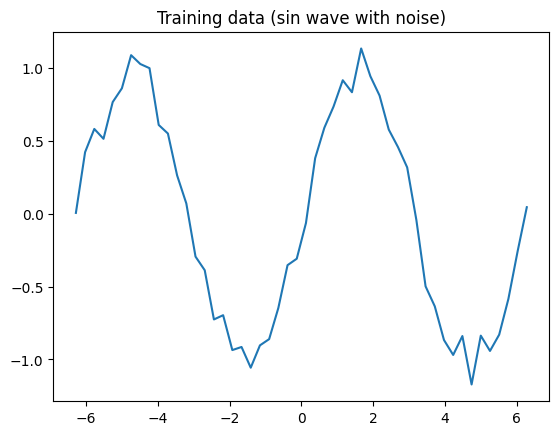

x: (40, 10, 1) t: (40, 10, 1)


In [3]:
x_data = np.linspace(-2*np.pi, 2*np.pi)
sin_data = np.sin(x_data) + 0.1 * np.random.randn(len(x_data))

plt.plot(x_data, sin_data)
plt.title("Training data (sin wave with noise)")
plt.show()

n_rnn = 10
n_sample = len(x_data) - n_rnn
x = np.zeros((n_sample, n_rnn))
t = np.zeros((n_sample, n_rnn))

for i in range(n_sample):
    x[i] = sin_data[i:i+n_rnn]
    t[i] = sin_data[i+1:i+n_rnn+1]

x = x.reshape(n_sample, n_rnn, 1)
t = t.reshape(n_sample, n_rnn, 1)
print("x:", x.shape, "t:", t.shape)


### テスト用の来予測関数を作成

In [4]:
def predict_future(model, x, n_rnn, steps=500):
    predicted = x[0].reshape(-1)
    for _ in range(len(x) + steps):
        y = model.predict(predicted[-n_rnn:].reshape(1, n_rnn, 1), verbose=0)
        predicted = np.append(predicted, y[0][-1][0])
    return predicted

### Simple LSTM

In [12]:
model_lstm = Sequential([
    LSTM(20, input_shape=(n_rnn, 1), return_sequences=True),
    Dense(1)
])
print(model_lstm.summary())

model_lstm.compile(loss="mse", optimizer="adam")
history_lstm = model_lstm.fit(x, t, epochs=50, batch_size=8, verbose=0, validation_split=0.1)
pred_lstm = predict_future(model_lstm, x, n_rnn)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 20)         │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10, 1)          │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,781 (6.96 KB)

 Trainable params: 1,781 (6.96 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - loss: 0.4858 - val_loss: 0.6061
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.4489 - val_loss: 0.5643
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4299 - val_loss: 0.5146
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4216 - val_loss: 0.4782
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3977 - val_loss: 0.4418
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3813 - val_loss: 0.4099
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3673 - val_loss: 0.3815
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3520 - val_loss: 0.3573
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3385 - val_loss: 0.3345
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3212 - val_loss: 0.3135
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3045 - val_loss: 0.2927
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2906 - val_loss: 0.

## Simple RNN
Kerasを使ってRNNを構築します。  
Kerasが持つRNNの中で一番シンプルなSimpleRNN層を使います。

In [13]:
model_rnn = Sequential([
    SimpleRNN(20, input_shape=(n_rnn, 1), return_sequences=True),
    Dense(1)
])
print(model_rnn.summary())

model_rnn.compile(loss="mse", optimizer="adam")
history_rnn = model_rnn.fit(x, t, epochs=50, batch_size=8, verbose=0, validation_split=0.1)
pred_rnn = predict_future(model_rnn, x, n_rnn)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 10, 20)         │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10, 1)          │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461 (1.80 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.8313 - val_loss: 0.9346
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.6947 - val_loss: 0.7815
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.5804 - val_loss: 0.6608
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.4779 - val_loss: 0.5646
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.4082 - val_loss: 0.4834
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.3494 - val_loss: 0.4145
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2992 - val_loss: 0.3551
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2641 - val_loss: 0.3047
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2379 - val_loss: 0.2670
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2139 - val_loss: 0.2365
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1884 - val_loss: 0.2135
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1705 - val_loss: 0.

### Simple Transformer

In [16]:
inputs = Input(shape=(n_rnn, 1))
x_tf = Dense(32)(inputs)  # embedding 的役割
attn_out = MultiHeadAttention(num_heads=2, key_dim=8)(x_tf, x_tf)
x_tf = Add()([x_tf, attn_out])  # 残差接続
x_tf = LayerNormalization()(x_tf)
x_tf = Dense(20, activation="relu")(x_tf)
outputs = Dense(1)(x_tf)

model_tf = Model(inputs, outputs)
model_tf.compile(loss="mse", optimizer="adam")
print(model_tf.summary())

model_tf = Model(inputs, outputs)
model_tf.compile(loss="mse", optimizer="adam")
history_tf = model_tf.fit(x, t, epochs=50, batch_size=8, verbose=0, validation_split=0.1)
pred_tf = predict_future(model_tf, x, n_rnn)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 10, 32)    │         64 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 32)    │      2,128 │ dense_9[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 32)    │          0 │ dense_9[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 32)    │         64 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 10, 20)    │        660 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 10, 1)     │         21 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,937 (11.47 KB)

 Trainable params: 2,937 (11.47 KB)

 Non-trainable params: 0 (0.00 B)

None


## 損失関数の比較

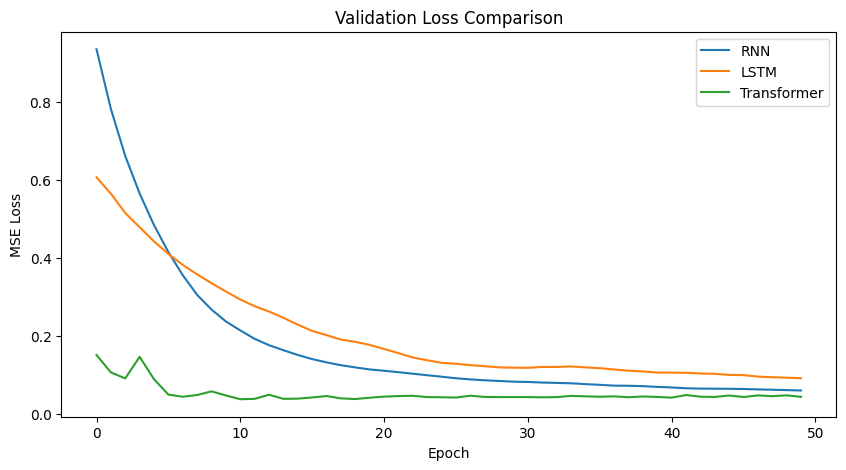

In [14]:
plt.figure(figsize=(10,5))
plt.plot(history_rnn.history["val_loss"], label="RNN")
plt.plot(history_lstm.history["val_loss"], label="LSTM")
plt.plot(history_tf.history["val_loss"], label="Transformer")
plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

## 推論による予測波形の表示

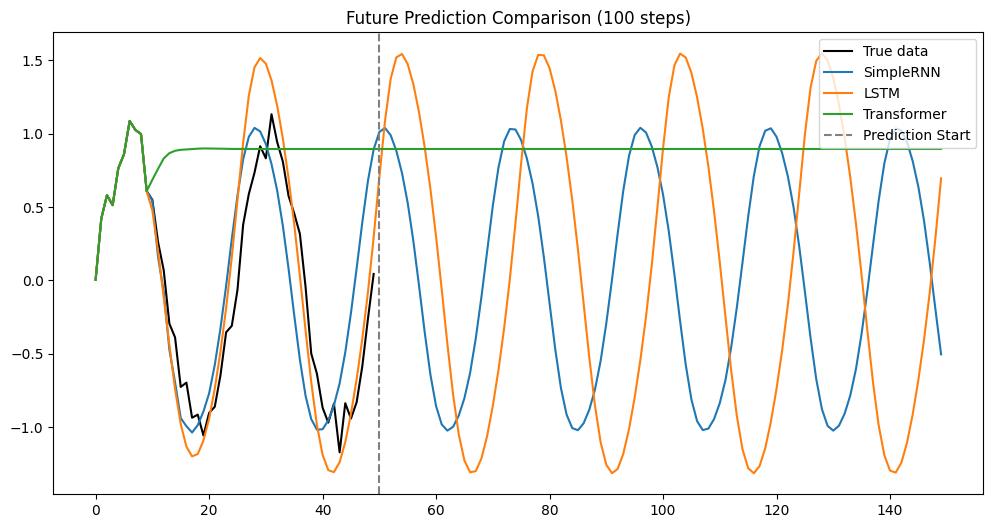

In [15]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(len(sin_data)), sin_data, label="True data", color="black", linewidth=1.5)
plt.plot(np.arange(len(pred_rnn)), pred_rnn, label="SimpleRNN")
plt.plot(np.arange(len(pred_lstm)), pred_lstm, label="LSTM")
plt.plot(np.arange(len(pred_tf)), pred_tf, label="Transformer")
plt.axvline(len(sin_data), color="gray", linestyle="--", label="Prediction Start")
plt.title("Future Prediction Comparison (100 steps)")
plt.legend()
plt.show()

"""
# 📘 モデル比較まとめ：SimpleRNN / LSTM / Transformer

##  SimpleRNN
### 概要
- 最も基本的な再帰型ニューラルネットワーク（Recurrent Neural Network）
- 現在の入力と「直前の出力状態」を再帰的に使って次を予測
- 時系列データを“逐次的”に処理する仕組み

### 特徴
- 短い依存関係（直近の傾向）を捉えるのは得意
- 長期依存（遠い過去の影響）を学習しづらい（勾配消失問題）
- モデル構造が単純で学習が速いが、波形が長期的にずれる傾向

### 本実験での挙動
- ノイズを含んだsin波の短周期はうまく追従
- ただし、周期が続くほど波形が徐々に平滑化・減衰するらしい
- 学習データが短い場合（1〜2周期）では安定だが長期予測に弱い

---

##  LSTM（Long Short-Term Memory）
### 概要
- RNNの勾配消失を防ぐために生まれた改良モデル
- 「セル状態」を内部に持ち、重要情報を保持・不要情報を忘却
- 入力・出力・忘却ゲートの3機構で情報を制御

### 特徴
- 長期依存の学習が可能（周期・トレンドの再現力が高い）
- 出力の滑らかさや周期再現性がRNNよりも安定
- ただし、データが少ないと振幅（上下のスケール）が過学習的に広がることがある

### 本実験での挙動
- 周期（波の長さ）はRNNより明確に再現
- ただし、振幅（縦方向のスケール）がやや大きくなる
- 少量データ＋Adam最適化による過適応傾向が見られる
- 対策としては正則化やデータ拡張、RMSPropなどの最適化が有効

---

##  Transformer
### 概要
- RNNやLSTMのような「再帰構造」を持たない新しいアーキテクチャ
- Attention機構により「過去の全入力」から関連度を動的に計算
- 位置情報（Positional Encoding）を与えることで時系列順序を理解

### 特徴
- 長期依存・複雑な時系列・非周期データの学習に非常に強い
- 並列計算が可能で学習効率が高い
- 少量データでは平均化傾向が強く、平坦な予測（直線）になりがち

### 本実験での挙動
- 損失関数（MSE）は最も小さい → 平均的に“安全な出力”を選択している
- しかし波形の追従性は低く、周期性を再現できない
- 原因は「位置情報の欠如」と「データ量不足」
- Positional Encodingを導入すると周期性が部分的に復活

---

## 総評（今回のsin波タスク）

| 観点 | SimpleRNN | LSTM | Transformer |
|------|------------|------|--------------|
| 波形の追従性 | ◯ | ◎ | △ |
| 長期予測の安定性 | △ | ◎ | ◯（位置情報次第） |
| 損失値（MSE） | 中 | 低 | 最低（ただし平坦化傾向） |
| 計算速度 | ◎（最速） | ◯ | △（Attention計算あり） |
| 少量データ適性 | ◎ | ◯ | × |
| 拡張余地 | 低 | 中 | 高（改良次第で最強） |

---

## まとめ
- **SimpleRNN**：時系列学習の原点。構造は単純で理解に最適。
- **LSTM**：実務レベルで最も安定。周期やトレンド再現に強い。
- **Transformer**：Attentionの威力で「過去全体」を見渡せるが、  
　位置情報と十分な学習データがなければ波形再現は困難。  
　時系列タスクではPositional Encodingの導入が必須。
